In [ ]:
!pip install super-gradients==3.2.0

In [ ]:
MODEL_ARCH = 'yolo_nas_l'
BATCH_SIZE = 12
MAX_EPOCHS = 20
EPOCHS = 20
CHECKPOINT_DIR = '/content'
EXPERIMENT_NAME = "Cascos"

In [ ]:
from tqdm.auto import tqdm

import os
import requests
import zipfile
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np
import random

from google.colab import drive
from google.colab import files

In [ ]:
# Montar Google Drive
drive.mount('/content/drive')

# Define el nombre de la carpeta de destino
destination_folder = '/content/Helm'

# Crea la carpeta
os.makedirs(destination_folder, exist_ok=True)

# Define la ruta del archivo ZIP
zip_file_path = '/content/drive/MyDrive/Helm.v5i.yolov5pytorch.zip'  # Cambia esta ruta según tu archivo

# Comando para descomprimir el archivo en la carpeta de destino
!unzip -q {zip_file_path} -d {destination_folder}

# Verificar que el archivo se descomprimió correctamente
!ls {destination_folder}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace /content/Helm/README.dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
from super_gradients.training import Trainer

trainer = Trainer(
    experiment_name = EXPERIMENT_NAME,
    ckpt_root_dir = CHECKPOINT_DIR
)

In [ ]:
ROOT_DIR = '/content/Helm'

classes = ['Helm']

dataset_params = {
    'data_dir':ROOT_DIR,
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes':classes
}

In [ ]:
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train,
    coco_detection_yolo_format_val
)

In [ ]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':2
    }
)

[2024-06-06 15:21:31] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 441/441 [00:00<00:00, 1795.80it/s]


In [ ]:
val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':2
    }
)

In [ ]:
test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':2
    }
)

In [ ]:
train_data.dataset.dataset_params['transforms'][1]

{'DetectionRandomAffine': {'degrees': 10.0, 'translate': 0.1, 'scales': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'filter_box_candidates': True, 'wh_thr': 2, 'area_thr': 0.1, 'ar_thr': 20}}

In [ ]:
train_data.dataset.transforms.pop(2)

DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114)

In [ ]:
train_data.dataset.dataset_params['transforms'][1]['DetectionRandomAffine']['degrees'] = 10.42

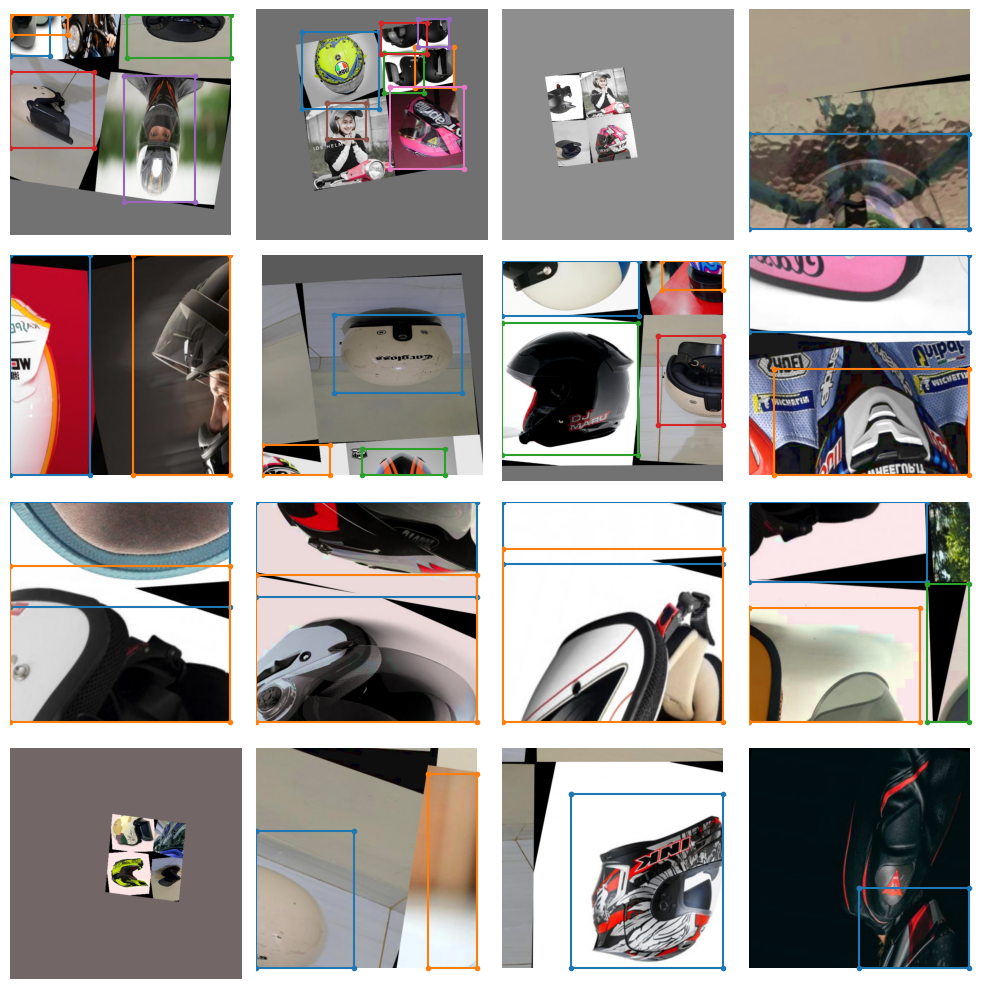

In [ ]:
train_data.dataset.plot()

In [ ]:
from super_gradients.training import models

model = models.get(
        MODEL_ARCH,
        num_classes=len(dataset_params['classes']),
        pretrained_weights="coco"
      )

[2024-06-06 15:21:56] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-06-06 15:21:57] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l


In [ ]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import (
    DetectionMetrics_050,
    DetectionMetrics_050_095
)
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

In [ ]:
train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        ),
        DetectionMetrics_050_095(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50:0.95'
}

In [ ]:
trainer.train(
        model=model,
        training_params=train_params,
        train_loader=train_data,
        valid_loader=val_data,
    )

The console stream is now moved to /content/Cascos/console_Jun06_15_22_08.txt


[2024-06-06 15:22:09] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2024-06-06 15:22:12] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 441        (len(train_set))
    - Batch size per GPU:           12         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             12         (num_gpus * batch_size)
    - Effective Batch size:         12         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         36         (len(train_loader))
    - Gradient updates per epoch:   36         (len(train_loader) / batch_accumulate)

[2024-06-06 15:22:12] INFO - sg_trainer.py - Started training for 20 epochs (0/19)

Validating: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]
[2024-06-06 15:23:04] INFO - base_sg_logger.py - 

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 2.441
│   ├── Ppyoloeloss/loss_iou = 0.222
│   ├── Ppyoloeloss/loss_dfl = 1.5545
│   └── Ppyoloeloss/loss = 3.7732
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.9926
    ├── Ppyoloeloss/loss_iou = 0.1196
    ├── Ppyoloeloss/loss_dfl = 1.1494
    ├── Ppyoloeloss/loss = 3.8663
    ├── Precision@0.50 = 0.0
    ├── Recall@0.50 = 0.0
    ├── Map@0.50 = 0.0493
    ├── F1@0.50 = 0.0
    ├── Precision@0.50:0.95 = 0.0
    ├── Recall@0.50:0.95 = 0.0
    ├── Map@0.50:0.95 = 0.0148
    └── F1@0.50:0.95 = 0.0



Validating epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]
[2024-06-06 15:24:33] INFO - base_sg_logger.py - Checkpoint saved in /content/Cascos/ckpt_best.pth
[2024-06-06 15:24:33] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.054947298020124435


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2537
│   │   ├── Epoch N-1      = 2.441  (↘ -1.1873)
│   │   └── Best until now = 2.441  (↘ -1.1873)
│   ├── Ppyoloeloss/loss_iou = 0.1773
│   │   ├── Epoch N-1      = 0.222  (↘ -0.0447)
│   │   └── Best until now = 0.222  (↘ -0.0447)
│   ├── Ppyoloeloss/loss_dfl = 1.3089
│   │   ├── Epoch N-1      = 1.5545 (↘ -0.2456)
│   │   └── Best until now = 1.5545 (↘ -0.2456)
│   └── Ppyoloeloss/loss = 2.3514
│       ├── Epoch N-1      = 3.7732 (↘ -1.4219)
│       └── Best until now = 3.7732 (↘ -1.4219)
└── Validation
    ├── Ppyoloeloss/loss_cls = 7.3702
    │   ├── Epoch N-1      = 2.9926 (↗ 4.3776)
    │   └── Best until now = 2.9926 (↗ 4.3776)
    ├── Ppyoloeloss/loss_iou = 0.3695
    │   ├── Epoch N-1      = 0.1196 (↗ 0.2499)
    │   └── Best until now = 0.1196 (↗ 0.2499)
    ├── Ppyoloeloss/loss_dfl = 2.2227
    │   ├── Epoch N-1      = 1.1494 (↗ 1.0733)
    │   └── Best until now = 1.1494 (↗ 1.0733)
    ├── Ppyoloeloss/loss = 9

Validating epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]
[2024-06-06 15:26:04] INFO - base_sg_logger.py - Checkpoint saved in /content/Cascos/ckpt_best.pth
[2024-06-06 15:26:04] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.12954315543174744


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.068
│   │   ├── Epoch N-1      = 1.2537 (↘ -0.1857)
│   │   └── Best until now = 1.2537 (↘ -0.1857)
│   ├── Ppyoloeloss/loss_iou = 0.1872
│   │   ├── Epoch N-1      = 0.1773 (↗ 0.01)
│   │   └── Best until now = 0.1773 (↗ 0.01)
│   ├── Ppyoloeloss/loss_dfl = 1.3292
│   │   ├── Epoch N-1      = 1.3089 (↗ 0.0203)
│   │   └── Best until now = 1.3089 (↗ 0.0203)
│   └── Ppyoloeloss/loss = 2.2007
│       ├── Epoch N-1      = 2.3514 (↘ -0.1507)
│       └── Best until now = 2.3514 (↘ -0.1507)
└── Validation
    ├── Ppyoloeloss/loss_cls = 4.8323
    │   ├── Epoch N-1      = 7.3702 (↘ -2.5379)
    │   └── Best until now = 2.9926 (↗ 1.8397)
    ├── Ppyoloeloss/loss_iou = 0.2634
    │   ├── Epoch N-1      = 0.3695 (↘ -0.1061)
    │   └── Best until now = 0.1196 (↗ 0.1438)
    ├── Ppyoloeloss/loss_dfl = 2.6332
    │   ├── Epoch N-1      = 2.2227 (↗ 0.4105)
    │   └── Best until now = 1.1494 (↗ 1.4838)
    ├── Ppyoloeloss/loss = 6.8073
 

Validating epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1096
│   │   ├── Epoch N-1      = 1.068  (↗ 0.0416)
│   │   └── Best until now = 1.068  (↗ 0.0416)
│   ├── Ppyoloeloss/loss_iou = 0.1946
│   │   ├── Epoch N-1      = 0.1872 (↗ 0.0074)
│   │   └── Best until now = 0.1773 (↗ 0.0173)
│   ├── Ppyoloeloss/loss_dfl = 1.3877
│   │   ├── Epoch N-1      = 1.3292 (↗ 0.0585)
│   │   └── Best until now = 1.3089 (↗ 0.0788)
│   └── Ppyoloeloss/loss = 2.29
│       ├── Epoch N-1      = 2.2007 (↗ 0.0893)
│       └── Best until now = 2.2007 (↗ 0.0893)
└── Validation
    ├── Ppyoloeloss/loss_cls = 4.807
    │   ├── Epoch N-1      = 4.8323 (↘ -0.0253)
    │   └── Best until now = 2.9926 (↗ 1.8144)
    ├── Ppyoloeloss/loss_iou = 0.3249
    │   ├── Epoch N-1      = 0.2634 (↗ 0.0615)
    │   └── Best until now = 0.1196 (↗ 0.2053)
    ├── Ppyoloeloss/loss_dfl = 2.8609
    │   ├── Epoch N-1      = 2.6332 (↗ 0.2278)
    │   └── Best until now = 1.1494 (↗ 1.7115)
    ├── Ppyoloeloss/loss = 7.0496
    

Validating epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.33it/s]


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1044
│   │   ├── Epoch N-1      = 1.1096 (↘ -0.0052)
│   │   └── Best until now = 1.068  (↗ 0.0364)
│   ├── Ppyoloeloss/loss_iou = 0.1901
│   │   ├── Epoch N-1      = 0.1946 (↘ -0.0045)
│   │   └── Best until now = 0.1773 (↗ 0.0128)
│   ├── Ppyoloeloss/loss_dfl = 1.36
│   │   ├── Epoch N-1      = 1.3877 (↘ -0.0277)
│   │   └── Best until now = 1.3089 (↗ 0.0511)
│   └── Ppyoloeloss/loss = 2.2596
│       ├── Epoch N-1      = 2.29   (↘ -0.0303)
│       └── Best until now = 2.2007 (↗ 0.0589)
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.7184
    │   ├── Epoch N-1      = 4.807  (↘ -2.0886)
    │   └── Best until now = 2.9926 (↘ -0.2742)
    ├── Ppyoloeloss/loss_iou = 0.2769
    │   ├── Epoch N-1      = 0.3249 (↘ -0.048)
    │   └── Best until now = 0.1196 (↗ 0.1573)
    ├── Ppyoloeloss/loss_dfl = 2.3675
    │   ├── Epoch N-1      = 2.8609 (↘ -0.4934)
    │   └── Best until now = 1.1494 (↗ 1.2181)
    ├── Ppyoloeloss/loss = 4.59

Validating epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.33it/s]
[2024-06-06 15:29:43] INFO - base_sg_logger.py - Checkpoint saved in /content/Cascos/ckpt_best.pth
[2024-06-06 15:29:43] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.1405908167362213


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0429
│   │   ├── Epoch N-1      = 1.1044 (↘ -0.0615)
│   │   └── Best until now = 1.068  (↘ -0.0251)
│   ├── Ppyoloeloss/loss_iou = 0.1847
│   │   ├── Epoch N-1      = 0.1901 (↘ -0.0054)
│   │   └── Best until now = 0.1773 (↗ 0.0074)
│   ├── Ppyoloeloss/loss_dfl = 1.3345
│   │   ├── Epoch N-1      = 1.36   (↘ -0.0255)
│   │   └── Best until now = 1.3089 (↗ 0.0255)
│   └── Ppyoloeloss/loss = 2.1719
│       ├── Epoch N-1      = 2.2596 (↘ -0.0877)
│       └── Best until now = 2.2007 (↘ -0.0288)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.6865
    │   ├── Epoch N-1      = 2.7184 (↘ -1.032)
    │   └── Best until now = 2.7184 (↘ -1.032)
    ├── Ppyoloeloss/loss_iou = 0.2558
    │   ├── Epoch N-1      = 0.2769 (↘ -0.0211)
    │   └── Best until now = 0.1196 (↗ 0.1362)
    ├── Ppyoloeloss/loss_dfl = 2.175
    │   ├── Epoch N-1      = 2.3675 (↘ -0.1926)
    │   └── Best until now = 1.1494 (↗ 1.0256)
    ├── Ppyoloeloss/loss = 3.

Validating epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]
[2024-06-06 15:31:05] INFO - base_sg_logger.py - Checkpoint saved in /content/Cascos/ckpt_best.pth
[2024-06-06 15:31:05] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.20006093382835388


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0467
│   │   ├── Epoch N-1      = 1.0429 (↗ 0.0038)
│   │   └── Best until now = 1.0429 (↗ 0.0038)
│   ├── Ppyoloeloss/loss_iou = 0.1728
│   │   ├── Epoch N-1      = 0.1847 (↘ -0.0119)
│   │   └── Best until now = 0.1773 (↘ -0.0045)
│   ├── Ppyoloeloss/loss_dfl = 1.2799
│   │   ├── Epoch N-1      = 1.3345 (↘ -0.0546)
│   │   └── Best until now = 1.3089 (↘ -0.029)
│   └── Ppyoloeloss/loss = 2.1186
│       ├── Epoch N-1      = 2.1719 (↘ -0.0533)
│       └── Best until now = 2.1719 (↘ -0.0533)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1823
    │   ├── Epoch N-1      = 1.6865 (↘ -0.5042)
    │   └── Best until now = 1.6865 (↘ -0.5042)
    ├── Ppyoloeloss/loss_iou = 0.2775
    │   ├── Epoch N-1      = 0.2558 (↗ 0.0217)
    │   └── Best until now = 0.1196 (↗ 0.1579)
    ├── Ppyoloeloss/loss_dfl = 2.2634
    │   ├── Epoch N-1      = 2.175  (↗ 0.0885)
    │   └── Best until now = 1.1494 (↗ 1.114)
    ├── Ppyoloeloss/loss = 3.0

Validating epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.033
│   │   ├── Epoch N-1      = 1.0467 (↘ -0.0137)
│   │   └── Best until now = 1.0429 (↘ -0.0099)
│   ├── Ppyoloeloss/loss_iou = 0.1732
│   │   ├── Epoch N-1      = 0.1728 (↗ 0.0004)
│   │   └── Best until now = 0.1728 (↗ 0.0004)
│   ├── Ppyoloeloss/loss_dfl = 1.2862
│   │   ├── Epoch N-1      = 1.2799 (↗ 0.0063)
│   │   └── Best until now = 1.2799 (↗ 0.0063)
│   └── Ppyoloeloss/loss = 2.1091
│       ├── Epoch N-1      = 2.1186 (↘ -0.0095)
│       └── Best until now = 2.1186 (↘ -0.0095)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2438
    │   ├── Epoch N-1      = 1.1823 (↗ 0.0615)
    │   └── Best until now = 1.1823 (↗ 0.0615)
    ├── Ppyoloeloss/loss_iou = 0.2702
    │   ├── Epoch N-1      = 0.2775 (↘ -0.0073)
    │   └── Best until now = 0.1196 (↗ 0.1506)
    ├── Ppyoloeloss/loss_dfl = 2.1227
    │   ├── Epoch N-1      = 2.2634 (↘ -0.1407)
    │   └── Best until now = 1.1494 (↗ 0.9733)
    ├── Ppyoloeloss/loss = 2.98

Validating epoch 8: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]
[2024-06-06 15:34:46] INFO - base_sg_logger.py - Checkpoint saved in /content/Cascos/ckpt_best.pth
[2024-06-06 15:34:46] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.24154488742351532


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9975
│   │   ├── Epoch N-1      = 1.033  (↘ -0.0355)
│   │   └── Best until now = 1.033  (↘ -0.0355)
│   ├── Ppyoloeloss/loss_iou = 0.164
│   │   ├── Epoch N-1      = 0.1732 (↘ -0.0093)
│   │   └── Best until now = 0.1728 (↘ -0.0088)
│   ├── Ppyoloeloss/loss_dfl = 1.2278
│   │   ├── Epoch N-1      = 1.2862 (↘ -0.0584)
│   │   └── Best until now = 1.2799 (↘ -0.0521)
│   └── Ppyoloeloss/loss = 2.0213
│       ├── Epoch N-1      = 2.1091 (↘ -0.0879)
│       └── Best until now = 2.1091 (↘ -0.0879)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1464
    │   ├── Epoch N-1      = 1.2438 (↘ -0.0974)
    │   └── Best until now = 1.1823 (↘ -0.0359)
    ├── Ppyoloeloss/loss_iou = 0.2531
    │   ├── Epoch N-1      = 0.2702 (↘ -0.0171)
    │   └── Best until now = 0.1196 (↗ 0.1335)
    ├── Ppyoloeloss/loss_dfl = 2.0194
    │   ├── Epoch N-1      = 2.1227 (↘ -0.1033)
    │   └── Best until now = 1.1494 (↗ 0.87)
    ├── Ppyoloeloss/loss = 

Validating epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]
[2024-06-06 15:37:15] INFO - base_sg_logger.py - Checkpoint saved in /content/Cascos/ckpt_best.pth
[2024-06-06 15:37:15] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.2857300341129303


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9709
│   │   ├── Epoch N-1      = 0.9975 (↘ -0.0266)
│   │   └── Best until now = 0.9975 (↘ -0.0266)
│   ├── Ppyoloeloss/loss_iou = 0.1629
│   │   ├── Epoch N-1      = 0.164  (↘ -0.001)
│   │   └── Best until now = 0.164  (↘ -0.001)
│   ├── Ppyoloeloss/loss_dfl = 1.2063
│   │   ├── Epoch N-1      = 1.2278 (↘ -0.0215)
│   │   └── Best until now = 1.2278 (↘ -0.0215)
│   └── Ppyoloeloss/loss = 1.9813
│       ├── Epoch N-1      = 2.0213 (↘ -0.0399)
│       └── Best until now = 2.0213 (↘ -0.0399)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1938
    │   ├── Epoch N-1      = 1.1464 (↗ 0.0473)
    │   └── Best until now = 1.1464 (↗ 0.0473)
    ├── Ppyoloeloss/loss_iou = 0.2429
    │   ├── Epoch N-1      = 0.2531 (↘ -0.0102)
    │   └── Best until now = 0.1196 (↗ 0.1233)
    ├── Ppyoloeloss/loss_dfl = 1.8225
    │   ├── Epoch N-1      = 2.0194 (↘ -0.1969)
    │   └── Best until now = 1.1494 (↗ 0.6731)
    ├── Ppyoloeloss/loss = 2

Validating epoch 10: 100%|██████████| 4/4 [00:02<00:00,  1.37it/s]


SUMMARY OF EPOCH 10
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9685
│   │   ├── Epoch N-1      = 0.9709 (↘ -0.0024)
│   │   └── Best until now = 0.9709 (↘ -0.0024)
│   ├── Ppyoloeloss/loss_iou = 0.1619
│   │   ├── Epoch N-1      = 0.1629 (↘ -0.001)
│   │   └── Best until now = 0.1629 (↘ -0.001)
│   ├── Ppyoloeloss/loss_dfl = 1.2155
│   │   ├── Epoch N-1      = 1.2063 (↗ 0.0092)
│   │   └── Best until now = 1.2063 (↗ 0.0092)
│   └── Ppyoloeloss/loss = 1.981
│       ├── Epoch N-1      = 1.9813 (↘ -0.0003)
│       └── Best until now = 1.9813 (↘ -0.0003)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.002
    │   ├── Epoch N-1      = 1.1938 (↘ -0.1917)
    │   └── Best until now = 1.1464 (↘ -0.1444)
    ├── Ppyoloeloss/loss_iou = 0.2779
    │   ├── Epoch N-1      = 0.2429 (↗ 0.0349)
    │   └── Best until now = 0.1196 (↗ 0.1583)
    ├── Ppyoloeloss/loss_dfl = 2.223
    │   ├── Epoch N-1      = 1.8225 (↗ 0.4005)
    │   └── Best until now = 1.1494 (↗ 1.0736)
    ├── Ppyoloeloss/loss = 2.808

Validating epoch 11: 100%|██████████| 4/4 [00:03<00:00,  1.33it/s]


SUMMARY OF EPOCH 11
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9247
│   │   ├── Epoch N-1      = 0.9685 (↘ -0.0437)
│   │   └── Best until now = 0.9685 (↘ -0.0437)
│   ├── Ppyoloeloss/loss_iou = 0.1576
│   │   ├── Epoch N-1      = 0.1619 (↘ -0.0043)
│   │   └── Best until now = 0.1619 (↘ -0.0043)
│   ├── Ppyoloeloss/loss_dfl = 1.1949
│   │   ├── Epoch N-1      = 1.2155 (↘ -0.0206)
│   │   └── Best until now = 1.2063 (↘ -0.0114)
│   └── Ppyoloeloss/loss = 1.9163
│       ├── Epoch N-1      = 1.981  (↘ -0.0647)
│       └── Best until now = 1.981  (↘ -0.0647)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0457
    │   ├── Epoch N-1      = 1.002  (↗ 0.0437)
    │   └── Best until now = 1.002  (↗ 0.0437)
    ├── Ppyoloeloss/loss_iou = 0.2651
    │   ├── Epoch N-1      = 0.2779 (↘ -0.0128)
    │   └── Best until now = 0.1196 (↗ 0.1455)
    ├── Ppyoloeloss/loss_dfl = 2.1511
    │   ├── Epoch N-1      = 2.223  (↘ -0.0719)
    │   └── Best until now = 1.1494 (↗ 1.0017)
    ├── Ppyoloeloss/loss 

Validating epoch 12: 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]


SUMMARY OF EPOCH 12
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9198
│   │   ├── Epoch N-1      = 0.9247 (↘ -0.0049)
│   │   └── Best until now = 0.9247 (↘ -0.0049)
│   ├── Ppyoloeloss/loss_iou = 0.1538
│   │   ├── Epoch N-1      = 0.1576 (↘ -0.0038)
│   │   └── Best until now = 0.1576 (↘ -0.0038)
│   ├── Ppyoloeloss/loss_dfl = 1.1868
│   │   ├── Epoch N-1      = 1.1949 (↘ -0.0081)
│   │   └── Best until now = 1.1949 (↘ -0.0081)
│   └── Ppyoloeloss/loss = 1.8979
│       ├── Epoch N-1      = 1.9163 (↘ -0.0184)
│       └── Best until now = 1.9163 (↘ -0.0184)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9548
    │   ├── Epoch N-1      = 1.0457 (↘ -0.0909)
    │   └── Best until now = 1.002  (↘ -0.0473)
    ├── Ppyoloeloss/loss_iou = 0.2779
    │   ├── Epoch N-1      = 0.2651 (↗ 0.0128)
    │   └── Best until now = 0.1196 (↗ 0.1583)
    ├── Ppyoloeloss/loss_dfl = 2.1688
    │   ├── Epoch N-1      = 2.1511 (↗ 0.0177)
    │   └── Best until now = 1.1494 (↗ 1.0194)
    ├── Ppyoloeloss/loss 

Validating epoch 13: 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]
[2024-06-06 15:43:59] INFO - base_sg_logger.py - Checkpoint saved in /content/Cascos/ckpt_best.pth
[2024-06-06 15:43:59] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3690382242202759


SUMMARY OF EPOCH 13
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9034
│   │   ├── Epoch N-1      = 0.9198 (↘ -0.0165)
│   │   └── Best until now = 0.9198 (↘ -0.0165)
│   ├── Ppyoloeloss/loss_iou = 0.1502
│   │   ├── Epoch N-1      = 0.1538 (↘ -0.0036)
│   │   └── Best until now = 0.1538 (↘ -0.0036)
│   ├── Ppyoloeloss/loss_dfl = 1.1616
│   │   ├── Epoch N-1      = 1.1868 (↘ -0.0253)
│   │   └── Best until now = 1.1868 (↘ -0.0253)
│   └── Ppyoloeloss/loss = 1.8597
│       ├── Epoch N-1      = 1.8979 (↘ -0.0382)
│       └── Best until now = 1.8979 (↘ -0.0382)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8714
    │   ├── Epoch N-1      = 0.9548 (↘ -0.0834)
    │   └── Best until now = 0.9548 (↘ -0.0834)
    ├── Ppyoloeloss/loss_iou = 0.253
    │   ├── Epoch N-1      = 0.2779 (↘ -0.0249)
    │   └── Best until now = 0.1196 (↗ 0.1334)
    ├── Ppyoloeloss/loss_dfl = 1.9837
    │   ├── Epoch N-1      = 2.1688 (↘ -0.1851)
    │   └── Best until now = 1.1494 (↗ 0.8343)
    ├── Ppyoloeloss/loss

Validating epoch 14: 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]


SUMMARY OF EPOCH 14
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8346
│   │   ├── Epoch N-1      = 0.9034 (↘ -0.0687)
│   │   └── Best until now = 0.9034 (↘ -0.0687)
│   ├── Ppyoloeloss/loss_iou = 0.141
│   │   ├── Epoch N-1      = 0.1502 (↘ -0.0092)
│   │   └── Best until now = 0.1502 (↘ -0.0092)
│   ├── Ppyoloeloss/loss_dfl = 1.1196
│   │   ├── Epoch N-1      = 1.1616 (↘ -0.042)
│   │   └── Best until now = 1.1616 (↘ -0.042)
│   └── Ppyoloeloss/loss = 1.7468
│       ├── Epoch N-1      = 1.8597 (↘ -0.1128)
│       └── Best until now = 1.8597 (↘ -0.1128)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8801
    │   ├── Epoch N-1      = 0.8714 (↗ 0.0087)
    │   └── Best until now = 0.8714 (↗ 0.0087)
    ├── Ppyoloeloss/loss_iou = 0.2641
    │   ├── Epoch N-1      = 0.253  (↗ 0.0111)
    │   └── Best until now = 0.1196 (↗ 0.1445)
    ├── Ppyoloeloss/loss_dfl = 2.1101
    │   ├── Epoch N-1      = 1.9837 (↗ 0.1264)
    │   └── Best until now = 1.1494 (↗ 0.9607)
    ├── Ppyoloeloss/loss = 2.5

Validating epoch 15: 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]


SUMMARY OF EPOCH 15
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8476
│   │   ├── Epoch N-1      = 0.8346 (↗ 0.013)
│   │   └── Best until now = 0.8346 (↗ 0.013)
│   ├── Ppyoloeloss/loss_iou = 0.1417
│   │   ├── Epoch N-1      = 0.141  (↗ 0.0007)
│   │   └── Best until now = 0.141  (↗ 0.0007)
│   ├── Ppyoloeloss/loss_dfl = 1.1114
│   │   ├── Epoch N-1      = 1.1196 (↘ -0.0082)
│   │   └── Best until now = 1.1196 (↘ -0.0082)
│   └── Ppyoloeloss/loss = 1.7576
│       ├── Epoch N-1      = 1.7468 (↗ 0.0108)
│       └── Best until now = 1.7468 (↗ 0.0108)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8944
    │   ├── Epoch N-1      = 0.8801 (↗ 0.0143)
    │   └── Best until now = 0.8714 (↗ 0.023)
    ├── Ppyoloeloss/loss_iou = 0.2567
    │   ├── Epoch N-1      = 0.2641 (↘ -0.0074)
    │   └── Best until now = 0.1196 (↗ 0.1371)
    ├── Ppyoloeloss/loss_dfl = 2.0304
    │   ├── Epoch N-1      = 2.1101 (↘ -0.0797)
    │   └── Best until now = 1.1494 (↗ 0.881)
    ├── Ppyoloeloss/loss = 2.5514
 

Validating epoch 16: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


In [ ]:
best_model = models.get(MODEL_ARCH,
          num_classes=len(dataset_params['classes']),
          checkpoint_path='/content/Cascos/ckpt_best.pth')

[2024-06-06 14:42:27] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/Cascos/ckpt_best.pth EMA checkpoint.


In [ ]:
trainer.test(model=best_model,
              test_loader=test_data,
              test_metrics_list=DetectionMetrics_050(
                                      score_thres=0.1,
                                      top_k_predictions=300,
                                      num_cls=len(dataset_params['classes']),
                                      normalize_targets=True,
                                      post_prediction_callback=PPYoloEPostPredictionCallback(
                                            score_threshold=0.01,
                                            nms_top_k=1000,
                                            max_predictions=300,
                                            nms_threshold=0.7)
                                                    )

            )

Testing: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]

{'PPYoloELoss/loss_cls': 1.2077678,
 'PPYoloELoss/loss_iou': 0.27438855,
 'PPYoloELoss/loss_dfl': 2.2583628,
 'PPYoloELoss/loss': 3.0229208,
 'Precision@0.50': 0.016788320615887642,
 'Recall@0.50': 1.0,
 'mAP@0.50': 0.5625776052474976,
 'F1@0.50': 0.03302225098013878}

Testing: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


[2024-06-06 14:45:54] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


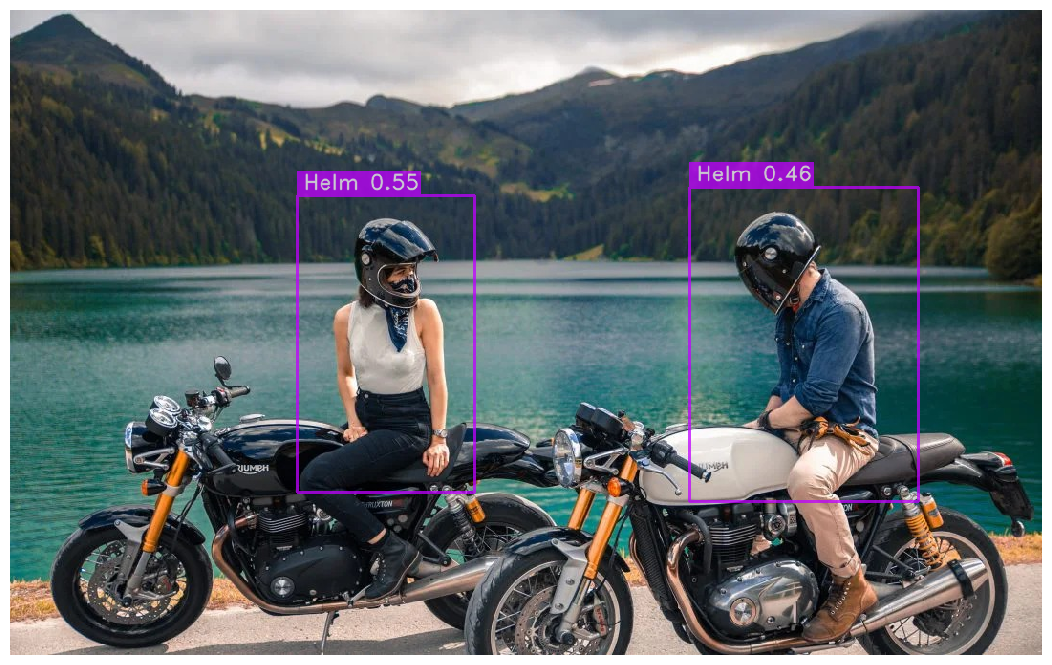

In [ ]:
path = "/content/Motos.jpeg"

best_model.predict(path, conf=0.46).show()

In [ ]:
!apt-get install -y locales
!locale-gen en_US.UTF-8
!update-locale LANG=en_US.UTF-8

In [ ]:
!pip install opencv-python

In [ ]:
!pip install pytube

In [ ]:
from pytube import YouTube

youtube = YouTube("https://www.youtube.com/watch?v=amJ7EID9qtQ")

print(youtube.title)
video = youtube.streams.get_highest_resolution()
video.download()

In [ ]:
import torch
import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow
import torch

# Ruta del video
video_path = '/content/MotorcycleCompilation_Burnouts_Brutal_Soundsandmore.mp4'

# Captura de video
cap = cv.VideoCapture(video_path)

while True:
    # Leer frame por frame
    ret, frame = cap.read()

    if not ret:
        print("Error...")
        break

    # Convertir frame a escala de grises (opcional, dependiendo de tu aplicación)
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    # Realizar inferencia con YOLO-NAS en el frame actual
    frame = best_model(gray)

    # Dibujar las cajas de detección en el frame
    for result in results:
        for bbox in result.boxes:
            x1, y1, x2, y2 = bbox.xyxy
            label = bbox.cls
            confidence = bbox.conf

            # Dibujar la caja
            cv.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
            # Poner la etiqueta
            cv.putText(frame, f'{label} {confidence:.2f}', (int(x1), int(y1) - 10), cv.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

    # Mostrar el frame con las detecciones
    cv2_imshow(frame)

    # Salir del bucle si se presiona 'q'
    if cv.waitKey(1) == ord('q'):
        break

# Liberar la captura de video y destruir todas las ventanas
cap.release()
cv.destroyAllWindows()


In [ ]:
import torch
device = 0 if torch.cuda.is_available() else "cpu"

input_video_path = "/content/MotorcycleCompilation_Burnouts_Brutal_Soundsandmore.mp4"
output_video_path = "/content/Result_detection.mp4"

best_model.to(device).predict(input_video_path).save(output_video_path)

